# CAPP 30255 1 Advanced Machine Learning for PP
## Measuring Political Compatibility with node2vec and moral values scale
### Software Demonstration: Minimum Viable Product
### Authors: Andrei Bartra and Oscar Noriega


## Exotic libraries

In [3]:
#Installation of libraries
!pip install node2vec
!pip install fsspec 
!pip install dask

  Created wheel for node2vec: filename=node2vec-0.4.3-cp37-none-any.whl size=5980 sha256=beb58803e09f57b620f0642406084937c16259f1592ce79a58c931e19e9d0377
  Stored in directory: /root/.cache/pip/wheels/34/f4/60/55708b5e797260310451d919c8f898bbd4acd1901367001f20
Successfully built node2vec
     |████████████████████████████████| 112kB 2.9MB/s 


## Mainstream Libraries

In [4]:
# Basics
import os, sys

#Other libraries
import time
import pandas as pd
import numpy as np
import urllib.request

#Data parallel processing
import dask.dataframe as dd
import dask.bag as db


#Text data processing
import re
import fnmatch
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

#Dowloads
nltk.download('stopwords')

#Network Structure
import networkx as nx

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#node2vec
from node2vec import Node2Vec
from gensim.models import Word2Vec

#Trainning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR


#Additional Analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Settings

In [8]:
#Global options

TRAIN = False
STEMMER = False
if STEMMER:
    PS = PorterStemmer()
else:
    class default:
        def stem(self, x):
            return x
    PS = default()

BATCH_SIZE = 4
EMBED_SIZE = 128
LAB_SIZE = 185

# Local storage
from google.colab import drive 
drive.mount('/content/gdrive')
PATH = "gdrive/MyDrive/U Chicago/8. Q6/AML/Project"
#PATH = "gdrive/MyDrive/Project"



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Data Extraction
###Responsible: Andrei Bartra 
Webscrape from 'https://www.rev.com/blog/transcript-category/political-transcripts/page/109'

It does not run in Collab. It requires configuration of the Chrome and drivers


In [ ]:
#ws.crawler(load_time=1, test=1)

## Data Processing
### Reponsible: Oscar Noriega
To make the data processing more efficient we used Dask that uses delayed objects and optmize the parallelization


In [9]:
def text_cleaning(text):
    '''
    Eliminates tabs and empty lines in a raw text from the REV.com webscrape.
      input: 
        text: raw text from the REV.com webscrape
      output: 
        text: clean text
    '''
    text = re.sub('	 ', '', text)
    text = re.sub('\n', '', text)
    return text

## Procedural code:

# Adding text files into a Dask bag
bag = db.read_text(PATH + "/data/transcripts/*.txt")

#Cleaning that allows the text data to be loaded in a dataframe
bag = bag.map(text_cleaning).filter(lambda x: x != '')

#Dataframe is small enough to run in memory. However, it is a single series
#where speaker and speech alternate
raw = bag.to_dataframe().compute()

#Reshaping the dataframe to have a speaker and speech in every row
speaker = raw.loc[raw[0].str.contains("\ \(.*\):$")].reset_index(drop=True)
speech = raw.loc[raw[0].str.contains("\ \(.*\):$") == False].reset_index(drop=True)
df = pd.concat([speaker, speech], axis=1)
df.columns = ['speaker', 'speech']

# Performing final data cleaning
df['speaker'] = df['speaker'].str.replace(r" \(.*\):","")
df['speech'] = df["speech"].str.replace(r"(\s*\[.*?\].\s*)", " ").str.strip()
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['speech'] = df['speech'].fillna('')
df["length"] = [len(x.split()) for x in df['speech'].tolist()] 
df['count'] = df['speaker'].map(df['speaker'].value_counts())
df = df.dropna()
df.head()

,speaker,speech,length,count
0,Merrick Garland,Good afternoon. I'm joined today by our recent...,179,5.0
1,Merrick Garland,They also assist police departments in develop...,159,5.0
2,Merrick Garland,It will also assess whether LMPD engages in di...,166,5.0
3,Merrick Garland,The investigation will be led by our Civil Rig...,174,5.0
4,Merrick Garland,We commend those measures and our investigatio...,124,5.0


## Adjusting Speaker Names
### Responsible: Oscar Noriega
On many cases they used different versions of th name of a person. For isntance: "President Joe Biden", "Joe Biden"

Also we drop generic speakers like: "Speaker or "crowd"

In [10]:
## Procedural code:

#Replacing Speaker Pelosi, to avoid confusion with the generic 'speaker'
df.loc[df['speaker'].str.contains("Pelosi"), 'speaker'] = 'Nancy Pelosi'

#Generic Speakers
drop = ['speaker', 'Speaker', 'Crowd', 'Chair Hall', 'Operator', 'Audience']

#Desambiguation of speakers
replace = ['Trump', 'Pence', 'Cuomo', 'DeWine', 'Biden', 'Psaki', 'Newsom']


df = df.drop(df[df['speaker'].str.contains('|'.join(drop), regex=True)].index)
for rep in replace:
    df['speaker'] = df['speaker'].apply(lambda x: rep if rep in x else x)


## Filtering:
### Responsible: Andrei Bartra
We are keeping speeches of minimun **length of 20** and **speakers with at least 268** interventions.

We consider interventions of at least 20 words meaningful and we set the speaker filter to keep the most salient political personalities. Specifically 268 to keep Barak Obama in the sample.


In [11]:
df = df.loc[df.length >= 20]
df = df.loc[df['count'] >=268]
spkr = df.groupby('speaker')['count'].max()
spkr.sort_values(ascending=False)


speaker
Trump               5893.0
Psaki               4777.0
Biden               3588.0
Nancy Pelosi        1146.0
Pence               1130.0
Cuomo               1130.0
DeWine               881.0
Boris Johnson        875.0
Kamala Harris        833.0
Newsom               604.0
Kayleigh McEnany     564.0
Rudy Giuliani        545.0
Jerome Powell        512.0
Kevin McCarthy       459.0
Gabriel Sterling     419.0
Daniel Andrews       398.0
Ned Price            348.0
Chuck Schumer        346.0
Lindsey Graham       344.0
Dr. Fauci            341.0
Mitch McConnell      336.0
Mr. Comey            285.0
Vladimir Putin       276.0
Eric Nelson          274.0
Barack Obama         268.0
Name: count, dtype: float64

## Auxiliary Data
### Responsible: Oscar Noriega

Information required to label words with a moral value

 - Moral Foundations Dictionary
 - Composite words
    - The moral foundations considers a set of composite words in the dictionary

In [12]:
# Moral foundations dictionary 2.0 with mora foundation index
mfd = pd.read_csv(PATH +  '/aml_proj/dictionaries/mfd2.0.dic', delimiter= '\t', skiprows=13, header=None, names=['words', 'map'])
# Moral foundations - indices map
mf_map = pd.read_csv(PATH +  '/aml_proj/dictionaries/mfd2.0.dic', delimiter= '\t', skiprows=1, nrows=10, header=None, names=['map', 'mf'])
#Merge word with moral founadtion
mfd = mfd.merge(mf_map, on='map', how='left')
#Identifyingg compound words and stemming
mfd['w_count'] = mfd['words'].str.split().str.len()
mfd['compound'] = mfd['words'].str.replace(' ', '')
mfd['stems'] = mfd['compound'].apply(lambda x:  PS.stem(x))

#Removing duplicate stems
mfd = mfd.drop_duplicates(subset='stems')
mfd.head()

,words,map,mf,w_count,compound,stems
0,compassion,1,care.virtue,1,compassion,compassion
1,empathy,1,care.virtue,1,empathy,empathy
2,kindness,1,care.virtue,1,kindness,kindness
3,caring,1,care.virtue,1,caring,caring
4,generosity,1,care.virtue,1,generosity,generosity


In [13]:
#Saving compound words apart
compound = mfd.loc[mfd['w_count']>1, ['words', 'compound']]
compound.to_csv(PATH +  '/aml_proj/dictionaries/compound.csv')
compound.head()

,words,compound
475,civil rights,civilrights
488,civil right,civilright
509,do unto others,dountoothers
510,golden rule,goldenrule
517,being objective,beingobjective


## Network Representation
### Responsible: Andrei Bartra
Considerations:
- Each intervention is an individual text (no sentences separation)
- Composite words from the dictionary are going to be considered as a single word


Search for the composite words and join them


In [14]:
def word_cleaning(text, composite, stops):
    '''
    Takes a speaker intervention, keep non-stop words, fusion composite words, 
    transform them to stems and forms the bigrams (edges) for the network structure
    Input:
      text: String.  A speaker intervention
      composite: DataFrame. composite word and its corresponding sequence of indvidual words
      stops: Set of stop words to avoid
    Output:
      bigrams: dictionary of edges
      words: the list of words (required later to estimate the index for each intervention) 
    '''
    #Composite words replace
    for row in composite.itertuples():
        text = re.sub(row[1], " " + row[2], text)
    # List of words only
    words = re.sub("[^a-zA-Z]", " ", text).lower().split()
    words = [PS.stem(w.strip()) for w in words if w not in stops and w.isalpha() ]
    #Remove stopping words, words with numbers and stemming
    bigrams = [(w , words[i+1])
             for i, w in enumerate(words) 
             if  i+1 < len(words)]
    return bigrams, words

In [15]:
def speech2edges(df, composite, stops):
    '''
    Iterates over the interventions, computing edges and creating the data objetcs for later
    Inputs:
      df: DataFrame with interventions
      composite: DataFrame. composite word and its corresponding sequence of indvidual words
      tops: Set of stop words to avoi
    Outputs
      edges: List of edges
      data: List of dictionaries with intervention id, speaker and list of words 
    '''
    edges = {}
    data = []
    for s in df.itertuples():
        bigrams, words = word_cleaning(s[2], composite, stops)
        data += [{'id': s[0], 'speaker': s[1], 'words' : words}]
        for bigram in bigrams:
            edges[bigram] = edges.get(bigram, 0) + 1 
    return edges, data
        

In [16]:
## Procedural code

#Creates the edges
start = time.time()
stops = set(stopwords.words("english"))
edges, docs = speech2edges(df, compound, stops)
print("--- %s seconds ---" % (time.time() - start))

--- 18.89005732536316 seconds ---


In [17]:
## Procedural code

#Creates network structure

G = nx.DiGraph()
for tup, weight in edges.items():
    G.add_edge(tup[0], tup[1], weight=weight)


In [18]:
#Some simple network statistics. 
#It is important to have a big strongly connected graph.

print("Nodes: %s" % len(G.nodes))
print("Edges: %s" % len(G.edges))
print("Is strongly connected: %s" % nx.is_strongly_connected(G))
print("Number of stromgly connected components: %s" % nx.number_strongly_connected_components(G))
print("Is weakly connected: %s" % nx.is_weakly_connected(G))
print("Number of weakly connected components: %s" % nx.number_weakly_connected_components(G))

Nodes: 24888
Edges: 605714
Is strongly connected: False
Number of stromgly connected components: 260
Is weakly connected: True
Number of weakly connected components: 1


### Node2Vec requires a strongly connected graph.
Luckily, we do not lose too many words by keeping the largest strongly connected component.

In [19]:
# The smallest componets are just a few words relative to the corpus
largest = max(nx.strongly_connected_components(G), key=len)
GS = G.subgraph(largest)
print("Nodes: %s" % len(GS.nodes))
print("Edges: %s" % len(GS.edges))

Nodes: 24629
Edges: 605388


### Visualizing the Graph

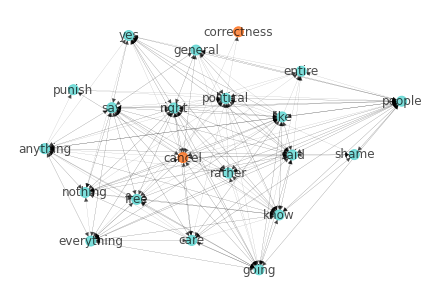

In [20]:
def explore_graph(relation):
    '''
    Display a graph of the words involved in the shortes paths between two words
    Input:
        relation: tuple with two strings
    Output:
        displays graph
    '''

    paths=list(nx.all_shortest_paths(G, source=relation[0], target=relation[1]))
    selected_nodes = list({x for l in paths for x in l})
    H = G.subgraph(selected_nodes)
    pos = nx.kamada_kawai_layout(H)
    color_map = []
    for node in H:
        if node  in relation:
            color_map.append('#FF6103')
        else: 
            color_map.append('#48D1CC')

    options = {
        "node_color": color_map,
        "width": weight/10,
        "with_labels": True,
        "edge_cmap": plt.cm.Blues,
        "node_size": 100,
        "alpha": 0.7
    }
    nx.draw(H, pos, **options)
    plt.show()

explore_graph(('cancel', 'correctness'))

### Training the embedding!!!...
####... or just loading the model we trainned overnight

In [21]:
if TRAIN:
    node2vec = Node2Vec(GS, dimensions=EMBED_SIZE, walk_length=80, 
                        num_walks=30, workers=1)
    model = node2vec.fit(window=15, min_count=1, batch_words=10, workers=1)
    model.save(PATH + '/aml_proj/models/model.model')
else:
    model = Word2Vec.load(PATH + '/aml_proj/models/model.model')
n2v_vocab = model.wv.vocab
n2v_embeddings = np.array([model.wv[x] for x in n2v_vocab])
n2v_embeddings= torch.from_numpy(n2v_embeddings)

### Testing the Embedding

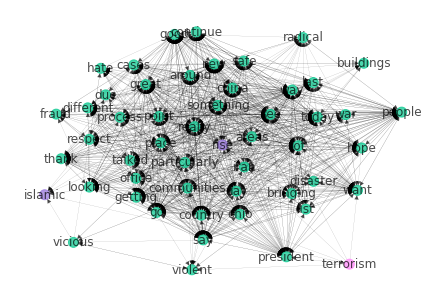

In [22]:
def see_related_words(key_word, th=0.8):
    test = model.wv.most_similar(key_word)

    selected_nodes = set()
    test = [ w for w, val in test if val >=th and w in GS.nodes]

    for w1 in test:
        for w2 in test:
            paths=list(nx.all_shortest_paths(GS, source=w1, target=w2))
            selected_nodes = selected_nodes.union({x for l in paths for x in l})
    H = GS.subgraph(selected_nodes)
    pos = nx.kamada_kawai_layout(H)
    test = [w for w in test if w != key_word]
    color_map = []
    for node in H:
        if node  in test:
            color_map.append('#9370DB')
        elif node == key_word:
            color_map.append('#FF83FA')
        else: 
            color_map.append('#00C78C')
    options = {
        "node_color": color_map,
        "width": weight/10,
        "with_labels": True,
        "edge_cmap": plt.cm.Blues,
        "node_size": 100,
        "alpha": 0.7
    }
    nx.draw(H, pos, **options)
    plt.show()
see_related_words('terrorism', th = 0.73)

## Predicting Moral values for words outside the dictionary
### Responsible: Oscar Noriega

### Helper Functions

In [23]:
def data_split(df, strata, props=[0.8, 0.1, 0.1]):
    '''
    Function to create stratified sampling for machine learning
    Inputs:
      df: datafrae with the data
      strata: column with a category for each strata (or combination of strata)
      props: proportions for Train, Validation and Test (in that order!)
    Output
      df: Dataframe with a column indicating each sample

    '''
    df['rand'] = np.random.uniform(size=len(df))
    df = df.sort_values(by = [strata, 'rand'])
    df['row_id']= df.groupby([strata])['rand'].transform('rank')
    df['n_rows'] = df.groupby([strata])['rand'].transform('count')
    df['rank'] =  df['row_id']/df['n_rows']

    props = [sum(props[:i])for i, _ in enumerate(props)] + [1.0]

    df['sample'] = pd.cut(df['rank'], props, labels=['Train', 'Val' ,'Test'])
    df = df.drop(['rand', 'row_id', 'n_rows', 'rank'], axis=1)
    return df

def collate_fn(batch):
    '''
    '''
    words = []
    labels = [] 
    for b in batch:
      labels.append(b[0])
      words.append(b[1])
    words = torch.tensor(words).to(torch.int64)
    labels = torch.tensor(labels)
    
    return labels, words


def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        for idx, (label, word) in enumerate(dataloader):
            log_probs = model(word)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count


def evaluate(model, data):
    model.eval()
    it = iter(data)
    total_count = 0. # Number of target words seen
    total_loss = 0. # Loss over all target words
    with torch.no_grad():
        for i, (label, word) in enumerate(it):
            output = model(word)
            loss = loss_function(output.view(-1, output.size(-1)), label.view(-1))
                    
            total_count += word.size()[0]
            total_loss += loss.item()*word.size()[0]
                
    loss = total_loss / total_count
    model.train()
    return loss

def train_an_epoch(dataloader, log_interval, optimizer):
    tagger.train() # Sets the module in training mode.

    for idx, (label, word) in enumerate(dataloader):
        tagger.zero_grad()
        probs = tagger(word)
        loss = loss_function(probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')


Get the tranning data set

In [323]:
# Procedural code

# Creating a dataframe for every word in the vocabulary an its repective moral value label
all_words = pd.DataFrame(GS.nodes)
all_words.columns = ['stems']
data = all_words.merge(mfd[['stems' ,'mf', 'map']], on='stems')
data.columns = ['stems' ,'y', 'mf_key']
data['mf_key'] =  data['mf_key'] - 1
data

,stems,y,mf_key
0,generous,care.virtue,0
1,christian,sanctity.virtue,8
2,order,authority.virtue,6
3,honor,authority.virtue,6
4,family,loyalty.virtue,4
...,...,...,...
1013,tricked,fairness.vice,3
1014,virgins,sanctity.virtue,8
1015,sleazy,sanctity.vice,9
1016,cheats,fairness.vice,3


In [324]:
#Verifying the partion is correct

data = data_split(data, 'y')
print(data.groupby(['y', 'sample'])['mf_key'].count())

y                 sample
authority.vice    Train      42
                  Val         5
                  Test        6
authority.virtue  Train     148
                  Val        18
                  Test       19
care.vice         Train     122
                  Val        15
                  Test       16
care.virtue       Train      90
                  Val        11
                  Test       12
fairness.vice     Train      88
                  Val        11
                  Test       12
fairness.virtue   Train      50
                  Val         6
                  Test        7
loyalty.vice      Train      12
                  Val         1
                  Test        2
loyalty.virtue    Train      71
                  Val         9
                  Test        9
sanctity.vice     Train      86
                  Val        11
                  Test       11
sanctity.virtue   Train     102
                  Val        13
                  Test       13
Name: mf_key, d

### Add keys to the node2vec embedding

In [325]:

vocab_keys = {w: i for i, w in enumerate(n2v_vocab)}
data['vocab_key'] = data['stems'].apply(lambda x: vocab_keys.get(x, np.nan))
all_words['vocab_key'] = all_words['stems'].apply(lambda x: vocab_keys.get(x, np.nan))
all_words = all_words.dropna()
data = data.dropna()
data['vocab_key'] = data['vocab_key'].astype(int)

In [55]:
data.groupby('mf_key')['vocab_key'].count()

mf_key
0    113
1    153
2     63
3    111
4     89
5     15
6    185
7     53
8    128
9    108
Name: vocab_key, dtype: int64

### Balancing Data

#### Under Sampling

In [326]:

data['rnd'] = np.random.uniform(size=len(data))
data = data.sort_values(['mf_key', 'rnd'])
data['mf_id'] = data.groupby('mf_key')['rnd'].rank(method='first', ascending=True)
data = data.loc[data['mf_id'] <= LAB_SIZE]
data.shape

(1018, 7)

#### Over Sampling

In [327]:
data['temp'] = round(data['mf_id']*LAB_SIZE/data.groupby('mf_key')['rnd'].transform('count'))
data['repeat'] = data['temp'] - data.groupby('mf_key')['temp'].shift(1)
data['repeat'] = data.loc[:, ['temp', 'repeat']].apply(lambda x: x[0] if np.isnan(x[1]) else x[1], axis=1 ).astype(int)
data = data.loc[data.index.repeat(data.repeat)]
data = data.drop(['mf_id', 'temp' ,'repeat'], axis=1)
data = data.loc[data.mf_key < 8]
data.groupby('mf_key')['rnd'].count()

mf_key
0    185
1    185
2    185
3    185
4    185
5    185
6    185
7    185
Name: rnd, dtype: int64

### Shuffling,  partitions and Dataloader


In [58]:

# A shuffle
data =  data.sample(frac=1).reset_index(drop=True)

#Data partitions ready to collate
data_train = list(data.loc[data['sample'] == 'Train', ['mf_key', 'vocab_key']].to_records(index =False))
data_val = list(data.loc[data['sample'] == 'Val', ['mf_key', 'vocab_key']].to_records(index =False))
data_test = list(data.loc[data['sample'] == 'Test', ['mf_key', 'vocab_key']].to_records(index =False))

#Dataloaders
train_dataloader = DataLoader(data_train, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(data_val, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(data_test, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

### Simple Neural Network Object

The dataset is quite small, so we are going to try several layers with dropouts

The embedding enters as pretrained embeddings to allow freezing


In [59]:



class NNMFDTagger(nn.Module):
    def __init__(self, 
                 num_labels, 
                 vocab_size,
                 embed_size, 
                 hidden_dim, 
                 drop_probs, 
                 nonlinearity,
                 embedding, 
                 freeze=True):

        super(NNMFDTagger, self).__init__()
        self.embedding =  nn.Embedding.from_pretrained(embedding, freeze=freeze)
        self.dp = [nn.Dropout(p=prob) for prob in  drop_probs]
        self.nonlinearity = nonlinearity
        self.linear1 = nn.Linear(embed_size, hidden_dim[0])
        self.linear2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.linear3 = nn.Linear(hidden_dim[1], hidden_dim[2])
        self.linear4 = nn.Linear(hidden_dim[2], hidden_dim[3])
        self.linear5 = nn.Linear(hidden_dim[3], hidden_dim[4])
        self.linear6 = nn.Linear(hidden_dim[4], num_labels)


    def forward(self, _input):
      x = self.embedding(_input)
      f = self.dp[2](x)
      #print('dropout', f.size())
      h1 = self.nonlinearity[0](self.linear1(f))
      h1 = self.dp[1](h1)
      h2 = self.nonlinearity[1](self.linear2(h1))
      h2 = self.dp[2](h2)
      h3 = self.nonlinearity[2](self.linear3(h2))
      h3 = self.dp[3](h3)
      h4 = self.nonlinearity[3](self.linear4(h3))
      h4 = self.dp[4](h4)
      h5 = self.nonlinearity[4](self.linear5(h4))
      rv = F.log_softmax(self.linear6(h5), dim=1)

      return rv

Epoch: 3: Loss improvement. From inf to 1.132
Epoch: 4: Loss improvement. From 1.132 to 1.069
Epoch: 5: Loss improvement. From 1.069 to 1.054
Epoch: 6: Loss improvement. From 1.054 to 0.788
Epoch: 18: Loss improvement. From 0.788 to 0.780
Epoch: 19: Loss improvement. From 0.780 to 0.762
Epoch: 30: Loss improvement. From 0.762 to 0.737


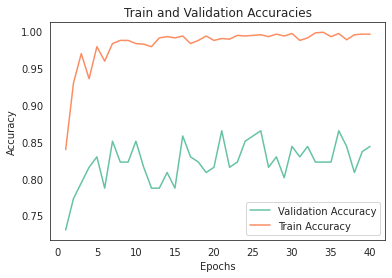

In [258]:
%matplotlib inline
num_labels = len(mf_map) -2
embd_size =  EMBED_SIZE
vocab_size = len(vocab_keys)
freeze = False

# Inputs
hidden_dim = [300, 400, 500, 100, 20]
drop_probs = [0.9, 0.8, 0.5, 0.3, 0.05]
nonlinearity = [nn.Tanh(), nn.ReLU(), nn.ReLU(), nn.CELU(), nn.CELU()]
loss_function = torch.nn.NLLLoss()

tagger = NNMFDTagger(num_labels,
                     vocab_size,
                     embd_size,
                     hidden_dim=hidden_dim,
                     drop_probs = drop_probs,
                     nonlinearity = nonlinearity,
                     embedding = n2v_embeddings,
                     freeze = freeze)

def train_algo(epochs, lr, tagger, epoch_log=50, backup=True, freeze=False):

    optimizer = torch.optim.Adam(tagger.parameters(), lr=lr)
    val_losses = []
    best_model = None
    best_loss = np.inf
    valid_accuracies = []
    train_accuracies = []
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_an_epoch(train_dataloader, epoch_log, optimizer)
        accuracy = get_accuracy(tagger, valid_dataloader)
        valid_accuracies.append(accuracy)
        train_accuracies.append(get_accuracy(tagger, train_dataloader))
        time_taken = time.time() - epoch_start_time
        #print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}.')
        if backup and epoch > 1:
                val_losses += [evaluate(tagger, valid_dataloader)]
                if len(val_losses) > 1 and val_losses[-1] < best_loss:
                    print(f'Epoch: {epoch}: Loss improvement. From {best_loss:.3f} to {val_losses[-1]:.3f}')
                    best_loss = val_losses[-1]
                    best_model = NNMFDTagger(num_labels,
                                             vocab_size,
                                             embd_size,
                                             hidden_dim=hidden_dim,
                                             drop_probs = drop_probs,
                                             nonlinearity = nonlinearity,
                                             embedding = n2v_embeddings,
                                             freeze=freeze)
                    best_model.load_state_dict(tagger.state_dict())
                    best_model = best_model
        else:
            best_model = tagger
        
    plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy')
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracies')
    plt.legend()
    plt.show()

    return best_model
if TRAIN:
    best_model_1 = train_algo(40, 1e-3, tagger, epoch_log=500, backup=True, freeze=freeze)

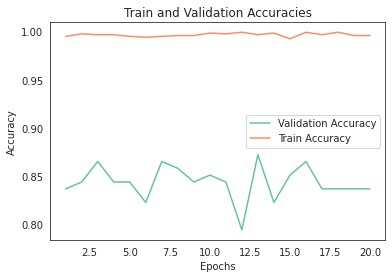

In [259]:
if TRAIN:
    best_model_2 = train_algo(20, 1e-4, best_model_1, epoch_log=500, backup=False, freeze=freeze)

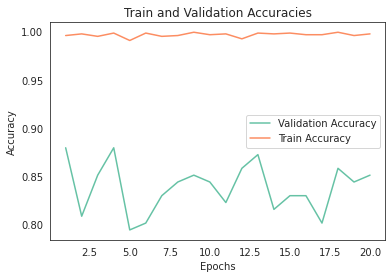

In [260]:
if TRAIN:
    best_model_3 = train_algo(20, 1e-5, best_model_2, epoch_log=500, backup=False, freeze=False)

In [261]:
if TRAIN:
    best_acc = 0
    best_tagger = None
    for i, tagger in enumerate([best_model_1, best_model_2, best_model_3]):
        best_model_1.eval()
        test_acc = get_accuracy(tagger, valid_dataloader)
        print(f'Model {i+1}: {test_acc:.3f}')
        if test_acc > best_acc:
            best_acc = test_acc
            best_tagger = tagger
    torch.save(best_tagger.state_dict(), (PATH + '/aml_proj/models/tagger.model'))
else:
    best_tagger = NNMFDTagger(num_labels,
                                             vocab_size,
                                             embd_size,
                                             hidden_dim=hidden_dim,
                                             drop_probs = drop_probs,
                                             nonlinearity = nonlinearity,
                                             embedding = n2v_embeddings,
                                             freeze=freeze)
    best_tagger.load_state_dict(torch.load(PATH + '/aml_proj/models/tagger.model'))

Model 1: 0.823
Model 2: 0.830
Model 3: 0.851


In [262]:
def get_preds(model, dataloader):
    model.eval()
    with torch.no_grad():    
        df = pd.DataFrame()
        for label, word in dataloader:
            log_probs = model(word)
            temp = pd.DataFrame({'y': label.detach().numpy(), 'y_hat': log_probs.argmax(1).detach().numpy()})
            df = df.append(temp, ignore_index=True)
    return df


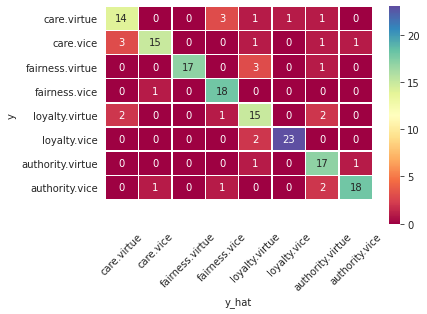

In [263]:
preds = get_preds(best_tagger, test_dataloader)
cf = pd.crosstab(preds['y'], preds['y_hat'], dropna=True)
annot_kws = {"ha": 'center',"va": 'center'}
ax = sns.heatmap(cf, linewidth=0.5, annot=True, fmt="d", annot_kws=annot_kws, cmap=plt.cm.Spectral )
ax.set(yticks=np.arange(0.5, 8.5, 1), 
       yticklabels=mf_map['mf'].to_list()[:-2], 
       xticklabels=mf_map['mf'].to_list()[:-2])
ax.set_ylim([9,0])
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [320]:
test_acc = get_accuracy(tagger, test_dataloader)
test_acc

0.8682634730538922

## Distribution of RUI per Speaker
### Responsible: Andrei Bartra

Generating the distribution of RUI for each speaker

### Getting all the probabilities in a dataframe to ease the calculations

In [328]:
best_tagger.eval()
all_probs = torch.exp(best_tagger(torch.tensor(all_words['vocab_key'].astype(int).to_list())))
all_probs = pd.DataFrame(all_probs.detach().numpy()).reset_index()
all_probs.columns = ['vocab_key'] + mf_map['mf'].to_list()[:-2]


all_words = all_words.merge(all_probs, on='vocab_key')
all_words = all_words.merge(mfd[['stems' ,'mf', 'map']], on='stems', how='left')
all_words 

,stems,vocab_key,care.virtue,care.vice,fairness.virtue,fairness.vice,loyalty.virtue,loyalty.vice,authority.virtue,authority.vice,mf,map
0,hello,587,1.269657e-01,3.604849e-04,4.570324e-05,8.723535e-01,1.266999e-04,1.841886e-08,2.573286e-06,1.452835e-04,NaN,NaN
1,south,868,5.047724e-03,1.258373e-02,3.716998e-01,3.884118e-02,1.082674e-02,1.383354e-02,4.267227e-01,1.204447e-01,NaN,NaN
2,carolina,416,7.745269e-05,8.701172e-04,2.698679e-06,3.142736e-08,3.858621e-03,5.999876e-05,9.951292e-01,1.898847e-06,NaN,NaN
3,want,261,9.234813e-03,1.556548e-02,3.869770e-03,4.482520e-04,7.524369e-02,6.911188e-03,8.878562e-01,8.705513e-04,NaN,NaN
4,thank,423,9.999455e-01,6.103303e-08,2.722206e-10,5.404940e-05,3.492055e-07,4.934541e-12,3.143635e-08,5.439494e-10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
24624,jealousy,23374,1.904038e-06,1.202612e-05,1.042986e-08,1.293273e-10,1.671737e-05,1.980848e-08,9.999694e-01,4.048072e-08,NaN,NaN
24625,hookup,20683,4.495684e-07,5.556717e-06,2.506432e-10,1.239393e-12,1.236128e-05,5.456112e-09,9.999816e-01,1.386091e-09,NaN,NaN
24626,mikey,3705,3.198059e-03,4.174669e-03,2.288704e-04,9.258653e-05,2.959011e-03,1.937188e-04,9.887404e-01,4.126786e-04,NaN,NaN
24627,misjudging,24172,1.000000e+00,7.516857e-13,6.216539e-15,4.804022e-09,2.708006e-10,2.839553e-17,1.029971e-12,1.784214e-14,NaN,NaN


Setting to 1 the known labels


In [329]:
cols = mf_map['mf'].to_list()[:-2]
for key in mf_map['map'].to_list()[:-2]:
    all_words.loc[all_words['map'] == key, cols] = 0
    all_words.loc[all_words['map'] == key, mf_map.loc[key-1].values[1]] = 1


## Eliminating Non-Informative words
### Words with close to uniform distributions

In [334]:
def topp_hhi(df, cols, p):
    df['hhi'] = 0 
    for col in cols:
        all_words['hhi'] = all_words['hhi'] + all_words[col]**2

    df = df.sort_values(by = 'hhi')
    df['rank'] = np.arange(len(df))/len(df)
    df['topk'] = df['rank'] >= 1 - p
    return df

all_words = topp_hhi(all_words,  mf_map['mf'].to_list()[:-2], 0.7)

top_words = all_words.loc[all_words.topk]
top_words.shape



(17240, 15)

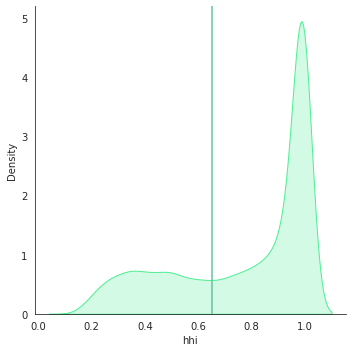

In [335]:
all_words = all_words.sort_values('hhi')
hhi_cut = int(all_words['topk'].argmax())
hhi_cut = all_words.iloc[hhi_cut]['hhi']
sns.set_style("white") 
sns.displot(all_words, x="hhi", kind="kde", fill=True, color="#4EEE94")
plt.axvline(hhi_cut, 0,1)

### Adjusting for dictionary overrepresentation
According to Enke paper


In [336]:

for mv in mf_map['mf'].to_list()[:-2]:
    top_words[mv] = top_words[mv]/top_words[mv].sum()
top_words



,stems,vocab_key,care.virtue,care.vice,fairness.virtue,fairness.vice,loyalty.virtue,loyalty.vice,authority.virtue,authority.vice,mf,map,hhi,rank,topk
67,know,36,1.271895e-06,6.663136e-06,4.454960e-08,1.246337e-09,2.895362e-04,3.702611e-05,1.060969e-04,3.921766e-08,NaN,NaN,0.651066,0.300012,True
20032,yohannes,12837,6.539158e-06,6.509249e-05,3.037250e-06,4.670262e-06,6.266125e-06,4.267031e-05,1.076843e-04,3.475920e-05,NaN,NaN,0.651084,0.300053,True
22903,rouhani,14373,5.515308e-06,3.225902e-05,2.360492e-05,4.092588e-04,2.283775e-06,7.135962e-06,1.743505e-06,9.005340e-05,NaN,NaN,0.651177,0.300093,True
12128,intrigued,17988,2.649571e-04,5.076563e-05,9.796198e-06,3.366598e-05,1.707952e-05,2.212525e-05,6.121290e-07,2.131669e-06,NaN,NaN,0.651182,0.300134,True
7374,hamilton,6359,1.992560e-05,3.923864e-04,6.054419e-06,1.718884e-05,7.341919e-06,1.364307e-04,6.176730e-06,2.977783e-05,NaN,NaN,0.651286,0.300175,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10856,modest,3954,5.765442e-25,5.586827e-22,8.309424e-04,2.173664e-20,4.140371e-13,1.439838e-13,7.389111e-17,6.852357e-11,NaN,NaN,1.000000,0.999797,True
21976,mdhs,22743,5.434131e-12,4.892164e-04,1.223812e-17,1.744642e-14,2.074005e-18,1.020093e-13,1.132649e-13,6.916040e-11,NaN,NaN,1.000000,0.999838,True
3446,joking,6286,1.849766e-12,2.531669e-15,1.284940e-22,2.618389e-29,1.499210e-03,1.663992e-11,8.061237e-12,1.475671e-21,NaN,NaN,1.000000,0.999878,True
22147,grandmotherly,8274,1.772911e-11,4.892164e-04,6.094659e-17,2.772912e-14,1.060779e-17,2.795886e-13,9.573677e-14,5.956350e-11,NaN,NaN,1.000000,0.999919,True


### Saving Model (dataframe) for User estimation

In [337]:
top_words[['stems'] + cols].to_csv(PATH + '/aml_proj/models/tagger.csv')

## Estimating RUI for all the political personalities
### Responsible Andrei Bartra


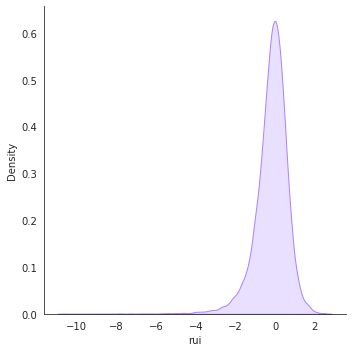

In [338]:
## Procedural code
# Get the dicrionary of interventions, convert into dataframe and change to
# Speakr-intervention-stem level
speech = pd.DataFrame(docs)
speech.columns = ['id', 'speaker', 'stems']
speech = speech.explode('stems', ignore_index=True)

#Get the probabilities from the model and compute RUI
speech = speech.merge(top_words[['stems'] + cols], on='stems', how='left')
speech['rui'] = speech['care.vice']      + speech['care.virtue'] + \
                speech['fairness.vice']  + speech['fairness.virtue'] - \
                speech['authority.vice'] - speech['authority.virtue'] - \
                speech['loyalty.vice']   - speech['loyalty.virtue']
speech = 1e4*speech.groupby(['speaker', 'id'])['rui'].mean()/2
speech = speech.reset_index()
sns.set_style("white") 
sns.displot(speech, x="rui", kind="kde", fill=True, color="#AB82FF")

## Eliminating Extreme values

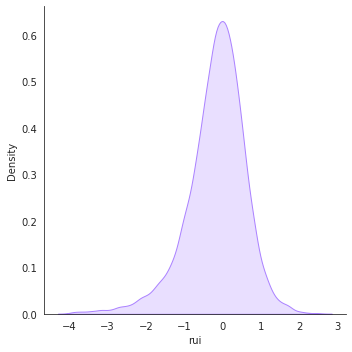

In [339]:
speech = speech.loc[abs(speech.rui)<4 ]
sns.displot(speech, x="rui", kind="kde", fill=True, color="#AB82FF")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

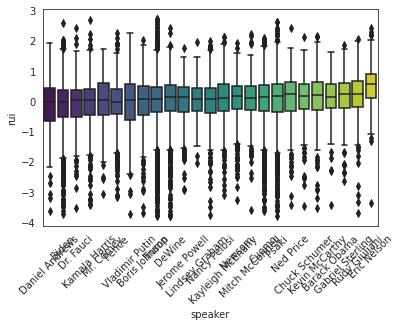

In [340]:
speech['rui'] =  speech['rui'] - speech['rui'].mean()
speech['order'] = speech.groupby('speaker').transform('mean')['rui']
speech = speech.sort_values('order')
ax = sns.boxplot(x="speaker", y="rui", data=speech, palette="viridis")
plt.xticks(rotation=45)

Text(0, 0.5, 'Density')

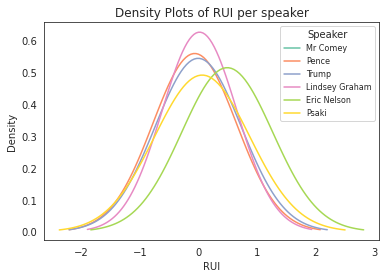

In [341]:
from scipy import stats
selected = ['Mr Comey' ,'Pence', 'Trump', 'Lindsey Graham', 'Eric Nelson', 'Psaki']
sns.set_palette("Set2", 8)
for person in selected:  
    subset = speech[speech['speaker'] == person]
    mu = subset.mean()['rui']
    variance = subset.var()['rui']
    sigma = (variance)**(1/2)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=person) 
    #subset.rui.plot.kde(label=person)
    
plt.legend(prop={'size': 8}, title = 'Speaker')
plt.title('Density Plots of RUI per speaker')
plt.xlabel('RUI')
plt.ylabel('Density')

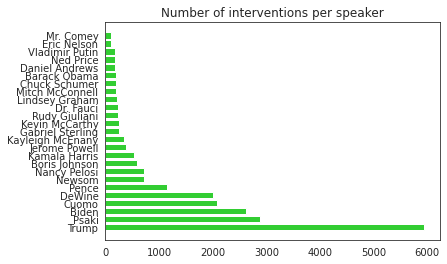

<Figure size 1440x720 with 0 Axes>

In [228]:
fig, ax = plt.subplots()

speech['intervention'] =1
interv = speech.groupby('speaker', as_index=False).agg({"intervention": "count"}).sort_values(by='intervention', ascending=True)
interventions = list(interv.intervention)
speakers = list(interv.speaker)
y_pos = np.arange(len(speakers))

ax.barh(y_pos, interventions, align='center', color='limegreen')
ax.set_yticks(y_pos)
ax.set_yticklabels(speakers)
ax.invert_yaxis()
ax.set_title('Number of interventions per speaker')
plt.figure(figsize=(20, 10))
plt.show()

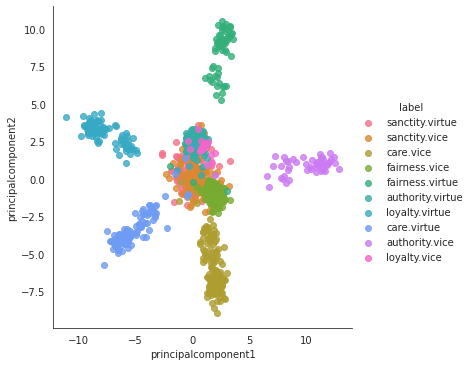

In [342]:
embed1 = pd.DataFrame(best_tagger.embedding.weight.detach().numpy())
fresh_node2vec = Word2Vec.load(PATH + '/aml_proj/models/model.model')
n2v_vocab = fresh_node2vec.wv.vocab
embed2 = np.array([fresh_node2vec.wv[x] for x in n2v_vocab])
embed2= pd.DataFrame(torch.from_numpy(embed2).detach().numpy())

def vis_embed(df, embed, kde=False):
    embed['vocab_key'] = embed.index
    df = df[['stems', 'vocab_key', 'mf']].dropna()
    df = df.merge(embed, on='vocab_key')

    scaler = StandardScaler()
    pca_input = scaler.fit_transform(df.iloc[:,-EMBED_SIZE: ])
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(pca_input)
    principalDf =pd.DataFrame(data = principalComponents, columns = ['principalcomponent1',  'principalcomponent2'])

    label = pd.DataFrame(list(df['mf']))
    principalDf = pd.concat([principalDf,df['mf']],axis = 1,join='inner', ignore_index=True)
    principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
    principalDf.columns = ["principalcomponent1", "principalcomponent2",'label'] 
    principalDf

    #eye_burn = ["#9b59b6", "#3498db", "orange"]
    sns.set_palette("Set2", 8)
    if kde:
        sns.kdeplot( x="principalcomponent1", y="principalcomponent2", data=principalDf, legend=False, hue='label')
    else:
        sns.lmplot( x="principalcomponent1", y="principalcomponent2", data=principalDf, fit_reg=False, hue='label')




vis_embed(all_words, embed1, kde=False)


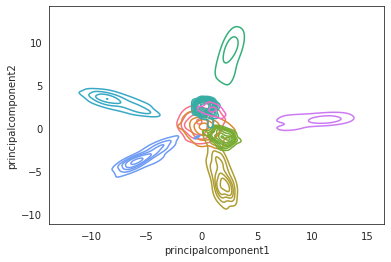

In [343]:
vis_embed(all_words, embed1, kde=True)

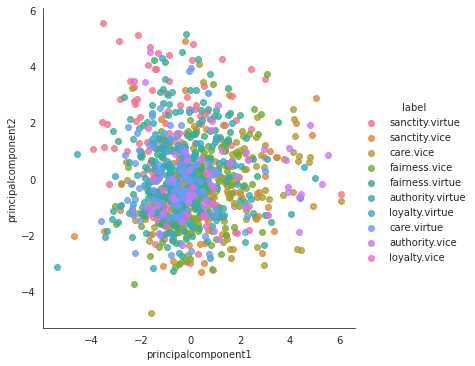

In [344]:
vis_embed(all_words, embed2, kde=False)

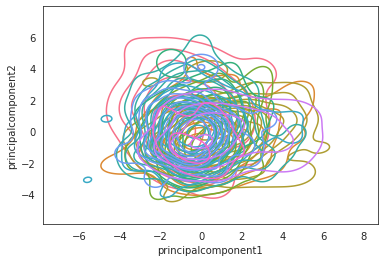

In [345]:
vis_embed(all_words, embed2, kde=True)


#Test your political compatibility!!!
## Responsible: Andrei Bartra

User interface:

Instructions:
1.   Fill the following  dictionary: https://forms.gle/yaBGq9UjkEPmdxim6
2.   Enter your username in the global NAME balow and run the code

Privacy notice:
Your answers are briefly stored in a google sheet document owned by Andrei Bartra. During the computing of the Relative Universalism Index the answers are deleted. 



In [ ]:
## Enter your name!
NAME = 'kyle'

### Test Functions

In [191]:
COMPOUND = compound[['words', 'compound']]
STOPS = set(stopwords.words("english"))

MODEL = top_words

def get_answers(user):
    data = urllib.request.urlopen(r'https://docs.google.com/spreadsheets/d/e/2PACX-1vSaQuHgU2GtSvAlMvYQ_cut6RcVpb7xlS3WcFhEw4QmK_HXC5yHQNHeE3S9ebgJczhmGobxBUd_MK2U/pub?output=csv') # it's a file like object and works just like a file
    mfq = pd.read_csv(data)
    mfq = mfq.fillna('')

    qs = ['q' + str(i) for i in range(11)]
    mfq.columns = ['time', 'user'] + qs
    mfq['tmp'] = ''
    mfq = mfq.loc[mfq['user'] == user]
    text = mfq['tmp'].str.cat(mfq[qs], sep=' ').values[0]
    return text

def text_cleaning(text, compound, stops):
    for row in compound.itertuples():
        text = re.sub(row[1], " " + row[2], text)
    # List of words only
    words = re.sub("[^a-zA-Z]", " ", text).lower().split()
    words = [PS.stem(w.strip()) for w in words if w not in stops and w.isalpha() ]
    return words

def run_model(words, model):

    words = pd.DataFrame(words)
    words.columns = ['stems']
    words = words.merge(model, on = 'stems', how='left')
    words['rui'] = words['care.vice']      + words['care.virtue'] + \
                   words['fairness.vice']  + words['fairness.virtue'] - \
                   words['authority.vice'] - words['authority.virtue'] - \
                   words['loyalty.vice']   - words['loyalty.virtue']
    words['rui'] = words['rui'] .fillna(0)
    return 1e4*words['rui'].mean()/2

def wrapper(user):
    text = get_answers(user)
    words = text_cleaning(text, COMPOUND, STOPS)
    rui = run_model(words, MODEL)
    return rui

Compatibility with Daniel Andrews: 0.445
Compatibility with Biden: 0.515
Compatibility with Dr. Fauci: 0.490
Compatibility with Kamala Harris: 0.490
Compatibility with Mr. Comey: 0.421
Compatibility with Pence: 0.556
Compatibility with Vladimir Putin: 0.429
Compatibility with Boris Johnson: 0.521
Compatibility with Trump: 0.542
Compatibility with DeWine: 0.506
Compatibility with Jerome Powell: 0.552
Compatibility with Lindsey Graham: 0.624
Compatibility with Nancy Pelosi: 0.534
Compatibility with Kayleigh McEnany: 0.476
Compatibility with Newsom: 0.570
Compatibility with Mitch McConnell: 0.504
Compatibility with Cuomo: 0.516
Compatibility with Psaki: 0.488
Compatibility with Ned Price: 0.458
Compatibility with Chuck Schumer: 0.497
Compatibility with Kevin McCarthy: 0.451
Compatibility with Barack Obama: 0.560
Compatibility with Gabriel Sterling: 0.532
Compatibility with Rudy Giuliani: 0.477
Compatibility with Eric Nelson: 0.417
Most compatible with Lindsey Graham, with 0.624 of compati

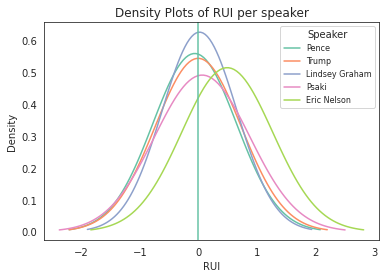

In [348]:



# Graph with:
selected = ['Mr Comey' ,'Pence', 'Trump', 'Lindsey Graham', 'Eric Nelson', 'Psaki']

rui = wrapper(NAME)
best = 0
for person in speech['speaker'].unique().tolist():  
    subset = speech[speech['speaker'] == person]
    mu = subset.mean()['rui']
    variance = subset.var()['rui']
    sigma = (variance)**(1/2)
    comp = stats.norm.pdf(rui, mu, sigma)
    print(f'Compatibility with {person}: {comp:.3f}')
    if comp > best:
        best = comp
        best_person = person
    if person in selected:
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=person) 
print(f'Most compatible with {best_person}, with {best:.3f} of compatibility')


plt.legend(prop={'size': 8}, title = 'Speaker')
plt.title('Density Plots of RUI per speaker')
plt.xlabel('RUI')
plt.ylabel('Density')
plt.axvline(rui, 0,1)
